In [1]:
import pandas as pd
import requests
from shapely import wkt
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd



In [15]:
gdf = pdf.read_file("noise_da123213ta.geojson")


NameError: name 'pdf' is not defined

In [ ]:
print(

### Getting the data

In [17]:
try:
    gdf = gpd.read_file("noise_data.geojson")
    print("file read succesfully!")
except NameError:
    print("data not found. using taxpayer money now to get data :)")
    api_url = 'https://admin.opendata.dk/api/3/action/datastore_search_sql'

    query = 'SELECT * FROM "d5f8f59f-78f1-4775-bc04-63992b9387fb" WHERE "KOMMUNE"=\'101\' OR "KOMMUNE"=\'147\''

    def fetch_data(sql_query):
        params = {'sql': sql_query}
        response = requests.get(api_url, params=params)

        if response.status_code == 200:
            data = response.json()['result']['records']
            return pd.DataFrame(data)
        else:
            print("Error:", response.status_code)
            return None

    data_101 = fetch_data(query)

    df = pd.DataFrame(data_101)


file read succesfully!


In [3]:
order = [
    "DATAEJER",
    "VEJBESTYRER",
    "VEJNR",
    "VEJDEL",
    "VEJNAVN",
    "KILOMETER",
    "METER",
    "LOKATION",
    "KOMMUNE",
    "AAR",
    "AADT",
    "TIMEANTAL07_19_MOTORKTJ",
    "TIMEANTAL19_22_MOTORKTJ",
    "TIMEANTAL22_07_MOTORKTJ",
    "GNSHAST07_19_MOTORKTJ",
    "GNSHAST19_22_MOTORKTJ",
    "GNSHAST22_07_MOTORKTJ",
    "TIMEANTAL07_19_0_580",
    "TIMEANTAL19_22_0_580",
    "TIMEANTAL22_07_0_580",
    "GNSHAST07_19_0_580",
    "GNSHAST19_22_0_580",
    "GNSHAST22_07_0_580",
    "TIMEANTAL07_19_580_1250",
    "TIMEANTAL19_22_580_1250",
    "TIMEANTAL22_07_580_1250",
    "GNSHAST07_19_580_1250",
    "GNSHAST19_22_580_1250",
    "GNSHAST22_07_580_1250",
    "TIMEANTAL07_19_O_1250",
    "TIMEANTAL19_22_O_1250",
    "TIMEANTAL22_07_O_1250",
    "GNSHAST07_19_O_1250",
    "GNSHAST19_22_O_1250",
    "GNSHAST22_07_O_1250",
    "KOOR_SDO"
]

df = df.reindex(columns=order)


In [4]:
gdf = gpd.GeoDataFrame(df,crs="EPSG:32632",geometry=df['KOOR_SDO'].apply(wkt.loads))
gdf.set_geometry("geometry")
gdf.drop(columns = ["KOOR_SDO"], inplace=True)



In [13]:
gdf.to_file('noise_data.geojson', driver='GeoJSON')  

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


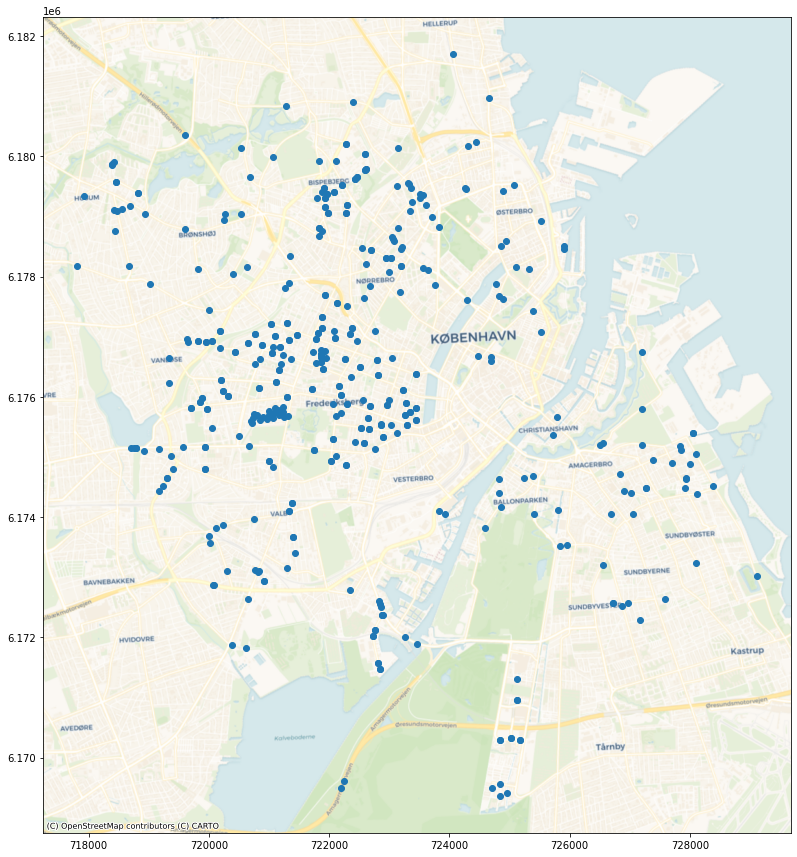

In [12]:


ax = gdf.plot(figsize = (15,15))



cx.add_basemap(
    ax, 
    crs="EPSG:32632",
    source=cx.providers.CartoDB.Voyager
)

plt.show()

In [9]:
cx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'OpenSeaMap': {'url': 'https://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
  'html_attribution': 'Map data: &copy; <a href="http://www.openseamap.org">OpenSeaMap</a> contributors',
  'attribution': 'Map data: (C) OpenSeaMap contributors',
  'name': 'OpenSeaMap'},
 'OPNVKarte': {'url': 'https://tileserver.memomaps.de/tilegen/{z}/{x}/{y}.png',
  'max_zoom': 18,
  'html_attribution': 'Map <a href="https://memomaps.de/">memomaps.de</a> <a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
  'attribution': 'Map memomaps.de CC-BY-SA, map data (C) OpenStreetMap contributors',
  'name': 'OPNVKarte'},
 'OpenTopoMap': {'url': 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
  'max_zoom': 17,
  'html_attribution': 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
  'attribution': 'Map data: (C) OpenStreetMap contributors, SRTM | Map style: (C) OpenTopoMap (CC-BY-SA)',
  'name': 'OpenTopoMap'},
 'OpenRailwayMap': {'url': 'https://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png',
  'max_zoom': 19,
 

### Calculating noise levels based on the observed data